<a href="https://colab.research.google.com/github/RagaaM/Scriba/blob/main/ShuffleNet_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms #for data augmentation; here, image transformations
import torchvision.datasets as dsets #for data loaders for popular vision datasets
from torchvision import  models #for definitions for popular model architectures
from torchsummary import summary #to get model summary after declaring it
from torch import nn,optim
import torch.nn.functional as functions #for non linear functions
import torchvision

import numpy as np
import pandas as pd

#core python packages
import os
import sys
import time
import math
import datetime as dt
import tqdm
import tarfile
import warnings
warnings.filterwarnings("ignore")

#for plotting images
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' #to set the device to be used by pytorch
best_acc = 0 #best test accuracy
start_epoch = 0 #start from epoch 0 or last checkpoint epoch
batch_size = 32
# 128 
weight_decay = 5e-4
momentum = 0.9
learning_rate = 0.01
epoch_size = 10
# 60

#declaring constant label mapper for CIFAR 10 dataset
LABEL_MAP = {0:'airplane', 1:'car', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

Files already downloaded and verified
Files already downloaded and verified


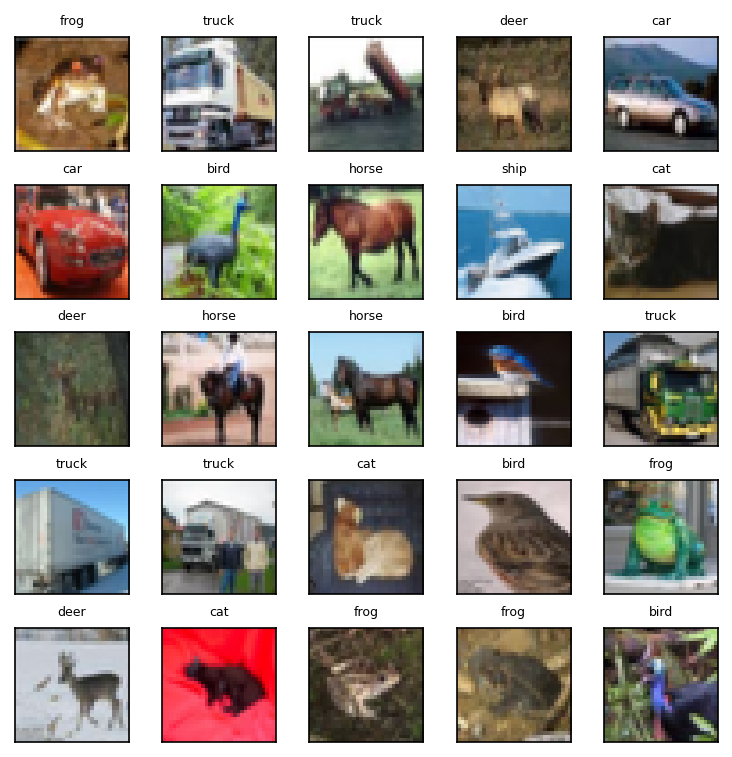

In [3]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(5, 5), dpi=150, facecolor='w', edgecolor='k')

#Exploring image dataset
def show_imgs(X):
  plt.figure(1)
  plt.rcParams.update({'font.size': 5})
  k=0
  for i in range(0,5):
    for j in range(0,5):
      plt.subplot2grid((5,5),(i,j))
      plt.title(LABEL_MAP[X[k][1]])
      plt.imshow(X[k][0])
      plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
      plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
      k = k+1
  #show the plot
  plt.tight_layout()
  plt.show()
root_path = '/content/drive/MyDrive/dataset'
data_train = dsets.CIFAR10(root=root_path, download = True)
data_test = dsets.CIFAR10(root=root_path, download=True, train=False)
show_imgs(data_train)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


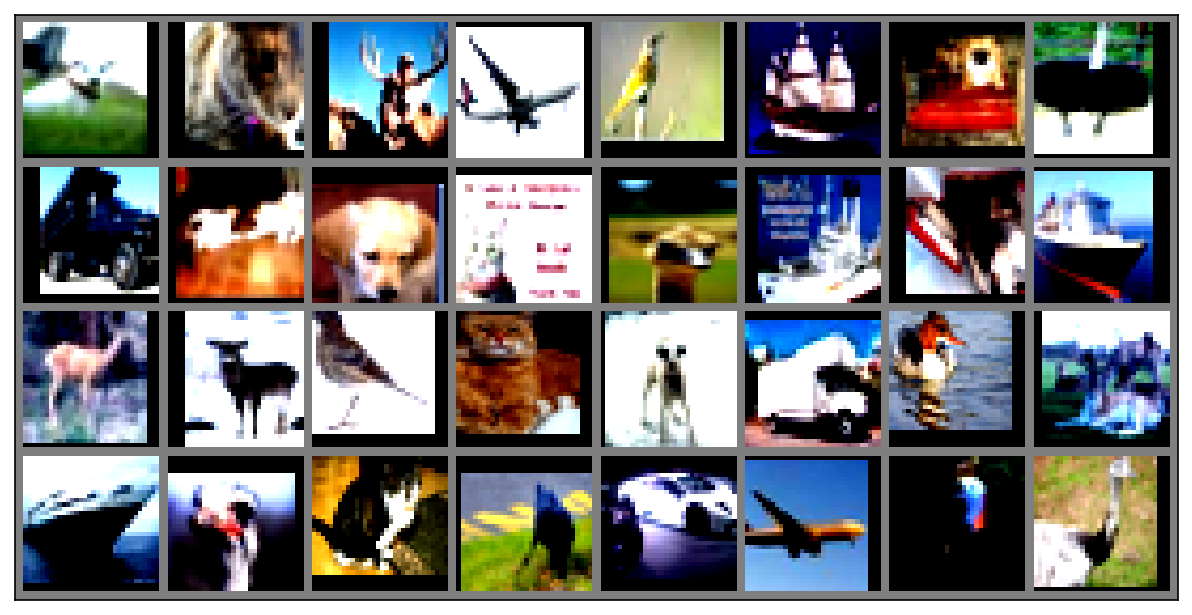

In [4]:
#defining transformation rules for training set
transform_train = transforms.Compose(transforms=[transforms.Pad(4), transforms.RandomHorizontalFlip(), transforms.RandomCrop(32), transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

#defining transformation rules for testing set
transform_test = transforms.Compose(transforms=[transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

train_set = dsets.CIFAR10(root=root_path, download = True, transform= transform_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = dsets.CIFAR10(root=root_path, download=True, train=False, transform= transform_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

#looking into the transformed images
figure(num=None, figsize=(10,8), dpi = 150, facecolor = 'w', edgecolor='k')
def imshow(img):
  img = img/2 + 0.5 #unnormalize
  np_img = img.numpy()
  plt.imshow(np.transpose(np_img, (1,2,0)))
  plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
  plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
  plt.show()

#get random training example images
data_iter = iter(train_loader)
images, labels = data_iter.next()

#understanding image tensor
images[0].shape

#show images
imshow(torchvision.utils.make_grid(images))

In [5]:
class ShuffleBlock(nn.Module):
  def __init__(self, groups):
    super(ShuffleBlock, self).__init__()
    self.groups = groups
  def forward(self, x):
    N,C,H,W = x.size()
    g = self.groups
    return x.view(N, g, C//g, H, W).permute(0, 2, 1, 3, 4).reshape(N, C, H, W)

In [6]:
class Bottleneck(nn.Module): 
  def __init__(self, in_planes, out_planes, stride, groups):
    super(Bottleneck, self).__init__()
    self.stride = stride
    mid_planes = int(out_planes/4)
    g = 1 if in_planes == 24 else groups
    self.conv1 = nn.Conv2d(in_planes, mid_planes, kernel_size=1, groups=g, bias=False)
    self.bn1 = nn.BatchNorm2d(mid_planes)
    self.shuffle1 = ShuffleBlock(groups= g)
    self.conv2 = nn.Conv2d(mid_planes, mid_planes, kernel_size=3, stride=stride, padding=1, groups=mid_planes, bias=False)
    self.bn2 = nn.BatchNorm2d(mid_planes)
    self.conv3 = nn.Conv2d(mid_planes, out_planes, kernel_size=1, groups=groups, bias=False)
    self.bn3 = nn.BatchNorm2d(out_planes)
    self.shortcut = nn.Sequential()
    if stride==2:
      self.shortcut = nn.Sequential(nn.AvgPool2d(3,stride=2, padding =1))
  def forward(self,x):
    out = functions.relu(self.bn1(self.conv1(x)))
    out = self.shuffle1(out)
    out = functions.relu(self.bn2(self.conv2(out)))
    out = self.bn3(self.conv3(out))
    res = self.shortcut(x)
    out = functions.relu(torch.cat([out,res], 1)) if self.stride==2 else functions.relu(out+res)
    return out

In [7]:
class ShuffleNet(nn.Module):
  def __init__(self, cfg):
    super(ShuffleNet, self).__init__()
    out_planes = cfg['out_planes']
    num_blocks = cfg['num_blocks']
    groups = cfg['groups']
    self.conv1 = nn.Conv2d(3, 24, kernel_size=1, bias = False)
    self.bn1 = nn.BatchNorm2d(24)
    self.in_planes = 24
    self.layer1 = self._make_layer(out_planes[0], num_blocks[0], groups)
    self.layer2 = self._make_layer(out_planes[1], num_blocks[1], groups)
    self.layer3 = self._make_layer(out_planes[2], num_blocks[2], groups)
    self.linear = nn.Linear(out_planes[2], 10) #10 as there are 10 classes

  def _make_layer(self, out_planes, num_blocks, groups):
    layers = []
    for i in range(num_blocks):
      stride = 2 if i == 0 else 1
      cat_planes = self.in_planes if i==0 else 0
      layers.append(Bottleneck(self.in_planes, out_planes-cat_planes, stride=stride, groups=groups))
      self.in_planes = out_planes
    return nn.Sequential(*layers)
  
  def forward(self,x):
    out = functions.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = functions.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out

In [8]:
def ShuffleNetG2():
  cfg = {'out_planes': [200, 400, 800],
         'num_blocks': [4, 8, 4],
         'groups': 2
         }
  return ShuffleNet(cfg)

def ShuffleNetG3():
  cfg = {'out_planes': [240, 480, 960],
         'num_blocks': [4, 8, 4],
         'groups': 3
         }
  return ShuffleNet(cfg)

#Shufflenet with groups = 2
net2 = ShuffleNetG2()
print("ShuffleNet with 2 Groups: " + str(net2))

#Shufflenet with groups = 3
net3 = ShuffleNetG3()
print("ShuffleNet with 3 Groups: " + str(net3))
#we will be using g=3 for training

#Setting the model with CUDA
if torch.cuda.is_available():
  net3.cuda()

ShuffleNet with 2 Groups: ShuffleNet(
  (conv1): Conv2d(3, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(24, 44, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shuffle1): ShuffleBlock()
      (conv2): Conv2d(44, 44, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=44, bias=False)
      (bn2): BatchNorm2d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(44, 176, kernel_size=(1, 1), stride=(1, 1), groups=2, bias=False)
      (bn3): BatchNorm2d(176, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): AvgPool2d(kernel_size=3, stride=2, padding=1)
      )
    )
    (1): Bottleneck(
      (conv1): Conv2d(200, 50, kernel_size=(1, 1),

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net3.parameters(), lr = learning_rate ,momentum= momentum, weight_decay=weight_decay)

In [10]:
def get_loss_acc(is_test_dataset = True):
  net3.eval()
  dataloader = test_loader if is_test_dataset else train-loader
  n_correct = 0
  n_total = 0
  test_loss = 0
  with torch.no_grad():
    for batch_size, (inputs, targets) in enumerate(dataloader):
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = net3(inputs)
      test_loss += criterion(outputs, targets).item()
      _, predicted = outputs.max(1)
      n_correct +=predicted.eq(targets).sum().item()
      n_total += targets.shape[0]

  return test_loss/(batch_size+1), n_correct/n_total

In [11]:
def train_model():
  net3.train()
  train_loss = 0
  n_correct = 0
  n_total = 0
  for batch_size, (inputs, targets) in enumerate(train_loader):
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()
    outputs = net3(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    _, predicted = outputs.max(1)
    n_correct +=predicted.eq(targets).sum().item()
    n_total += targets.shape[0]
  return train_loss/(batch_size+1), n_correct/n_total

In [12]:
def save_best_model(epoch):
  global best_acc
  net3.eval()
  test_loss = 0
  correct = 0
  total = 0
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(train_loader):
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = net3(inputs)
      loss = criterion(outputs, targets)
      test_loss += loss.item()
      _, predicted = outputs.max(1)
      total += targets.size(0)
      correct +=predicted.eq(targets).sum().item()
      print(batch_idx, len(train_loader), 'Loss: %.3f | Acc: %0.3f%% (Correct classifications %d/Total classifications %d)' % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

      #save checkpoint
      acc =100.*correct/total
      if acc>best_acc:
        print('Saving...')
        state = {'net': net3.state_dict(),
                 'acc': acc,
                 'epoch': epoch
                 }
        if not os.path.isdir('checkpoint'):
          os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        torch.save(net3, './checkpoint/net3.pth')
        best_acc = acc

In [13]:
EPOCH = epoch_size
training_time = dt.datetime.now()
start = dt.datetime.now()
start_epoch = 0
train_accuracy_list = []
test_accuracy_list = []
for epoch_i in range(start_epoch, start_epoch + EPOCH):
  global accuracy_list
  current_learning_rate = [i['lr'] for i in optimizer.param_groups][0]
  print('Batch Size', batch_size, '(%0.2fs)\n\nEpoch: %d/%d | Current Learning Rate: %.4f ' % ((dt.datetime.now() - start).seconds, epoch_i +1, EPOCH+start_epoch , current_learning_rate))
  start = dt.datetime.now()
  test_loss, test_acc = get_loss_acc()
  train_loss, train_acc = train_model()
  train_accuracy_list.append(train_acc*100)
  test_accuracy_list.append(test_acc*100)
  save_best_model(epoch_i)
  print('Train Loss: %.3f | Acc: %.3f%% \nTest Loss: %0.3f | Acc: %0.3f%% \n\n' % (train_loss, train_acc*100, test_loss, test_acc*100))

print('\n\nTotal Training time: %0.2f minutes ' %((dt.datetime.now() - training_time).seconds/60))

Streaming output truncated to the last 5000 lines.
1281 1563 Loss: 0.731 | Acc: 74.183% (Correct classifications 30433/Total classifications 41024)
1282 1563 Loss: 0.730 | Acc: 74.194% (Correct classifications 30461/Total classifications 41056)
1283 1563 Loss: 0.730 | Acc: 74.197% (Correct classifications 30486/Total classifications 41088)
1284 1563 Loss: 0.730 | Acc: 74.202% (Correct classifications 30512/Total classifications 41120)
1285 1563 Loss: 0.730 | Acc: 74.198% (Correct classifications 30534/Total classifications 41152)
1286 1563 Loss: 0.730 | Acc: 74.191% (Correct classifications 30555/Total classifications 41184)
1287 1563 Loss: 0.731 | Acc: 74.182% (Correct classifications 30575/Total classifications 41216)
1288 1563 Loss: 0.730 | Acc: 74.183% (Correct classifications 30599/Total classifications 41248)
1289 1563 Loss: 0.730 | Acc: 74.191% (Correct classifications 30626/Total classifications 41280)
1290 1563 Loss: 0.730 | Acc: 74.196% (Correct classifications 30652/Total cl

In [14]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

#seeing predictions of some images
def show_test_prediction_imgs(images, predicted_labels, real_labels):
  plt.figure(1, dpi = 150)
  plt.rcParams.update({'font.size': 5})
  k=0
  for i in range(0,3):
    for j in range(0,3):
      plt.subplot2grid((3,3),(i,j))
      plt.title('{0} -> {1} '.format(LABEL_MAP[real_labels[k].item()],LABEL_MAP[predicted_labels[k].item()]))
      unorm = UnNormalize(mean=(0.4914, 0.4822, 0.4465),std = (0.2023, 0.1994, 0.2010))
      image = unorm(images[k].cpu())
      plt.imshow(np.transpose(image.numpy(), (1,2,0)))
      plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
      plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
      k = k+1
  #show the plot
  plt.tight_layout()
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


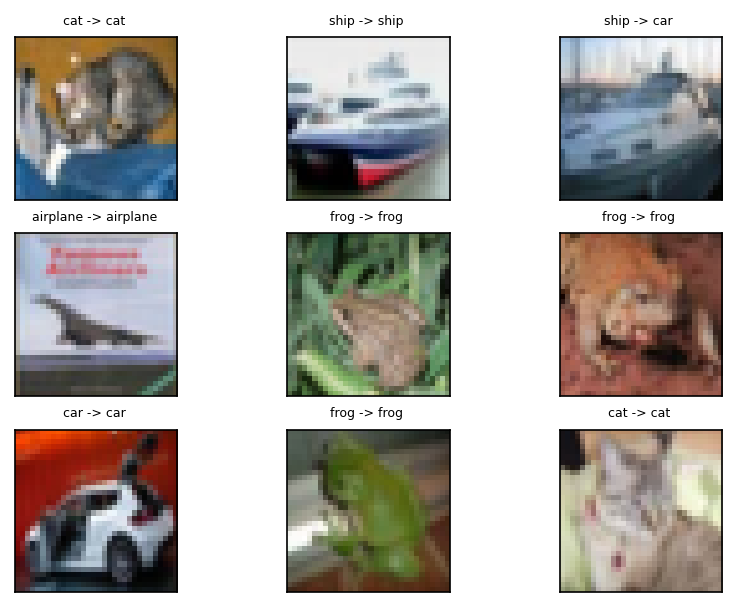

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


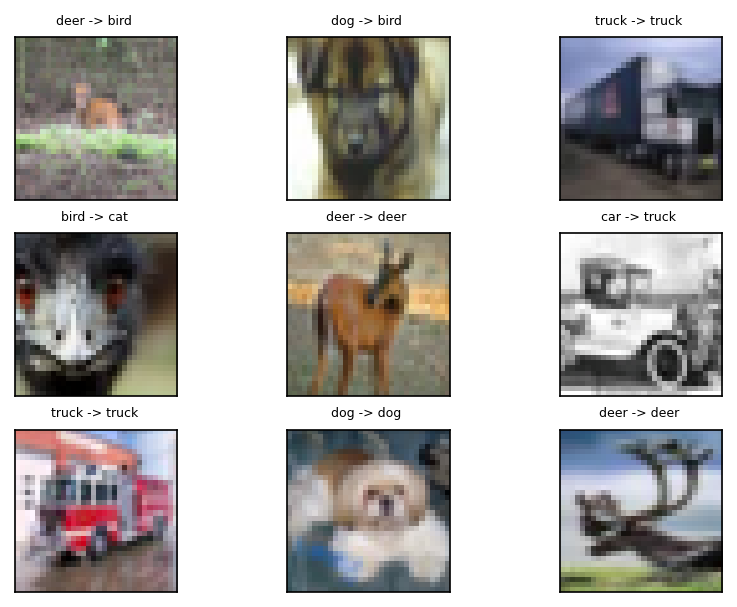

In [15]:
#Model Accuracy
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)

with torch.no_grad():
  for i,data in enumerate(test_loader):
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = net3(images)
    _, predicted = torch.max(outputs.data, 1)
    if(i in [0,1]):
      show_test_prediction_imgs(images, predicted, labels)
    total_images += labels.size(0)
    total_correct += (predicted == labels).sum().item()
    for i, l in enumerate(labels):
      confusion_matrix[l.item(), predicted[i].item()] +=1

In [16]:
print('{0:10s} - {1}'.format('Category', 'Accuracy'))
for i, r in enumerate(confusion_matrix):
  print('{0:10s} - {1:0.1f}'.format(LABEL_MAP[i], r[i]/np.sum(r)*100))
model_accuracy = total_correct/total_images *100
print('Model Accuracy on {0} test images : {1:.2f} %'.format(total_images, model_accuracy))

Category   - Accuracy
airplane   - 81.7
car        - 90.0
bird       - 73.6
cat        - 65.4
deer       - 79.8
dog        - 71.4
frog       - 90.3
horse      - 78.9
ship       - 83.8
truck      - 92.6
Model Accuracy on 10000 test images : 80.75 %


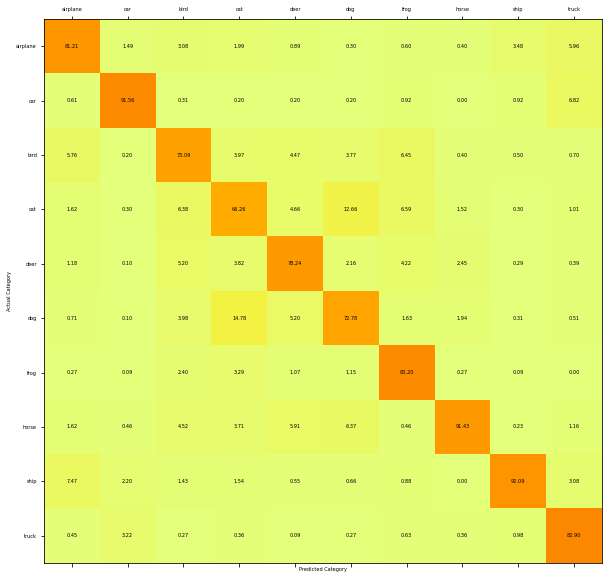

In [17]:
    fig, axis = plt.subplots(1,1,figsize = (10,10))
axis.matshow(confusion_matrix, aspect='auto', vmin = 0, vmax = 1000, cmap= plt.get_cmap('Wistia'))
for (i, j), z in np.ndenumerate(confusion_matrix):
  axis.text(j, i, '{:0.2f}'.format( z/np.sum(confusion_matrix, 0)[i]*100), ha='center', va='center')
plt.ylabel('Actual Category')
plt.yticks(range(10), LABEL_MAP.values())
plt.xlabel('Predicted Category')
plt.xticks(range(10), LABEL_MAP.values())
plt.rcParams.update({'font.size': 14})
plt.show()